In [1]:
from utils import *
from models import *


import os
os.chdir('../..')
print(os.getcwd())

/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu
using device:  cpu
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns


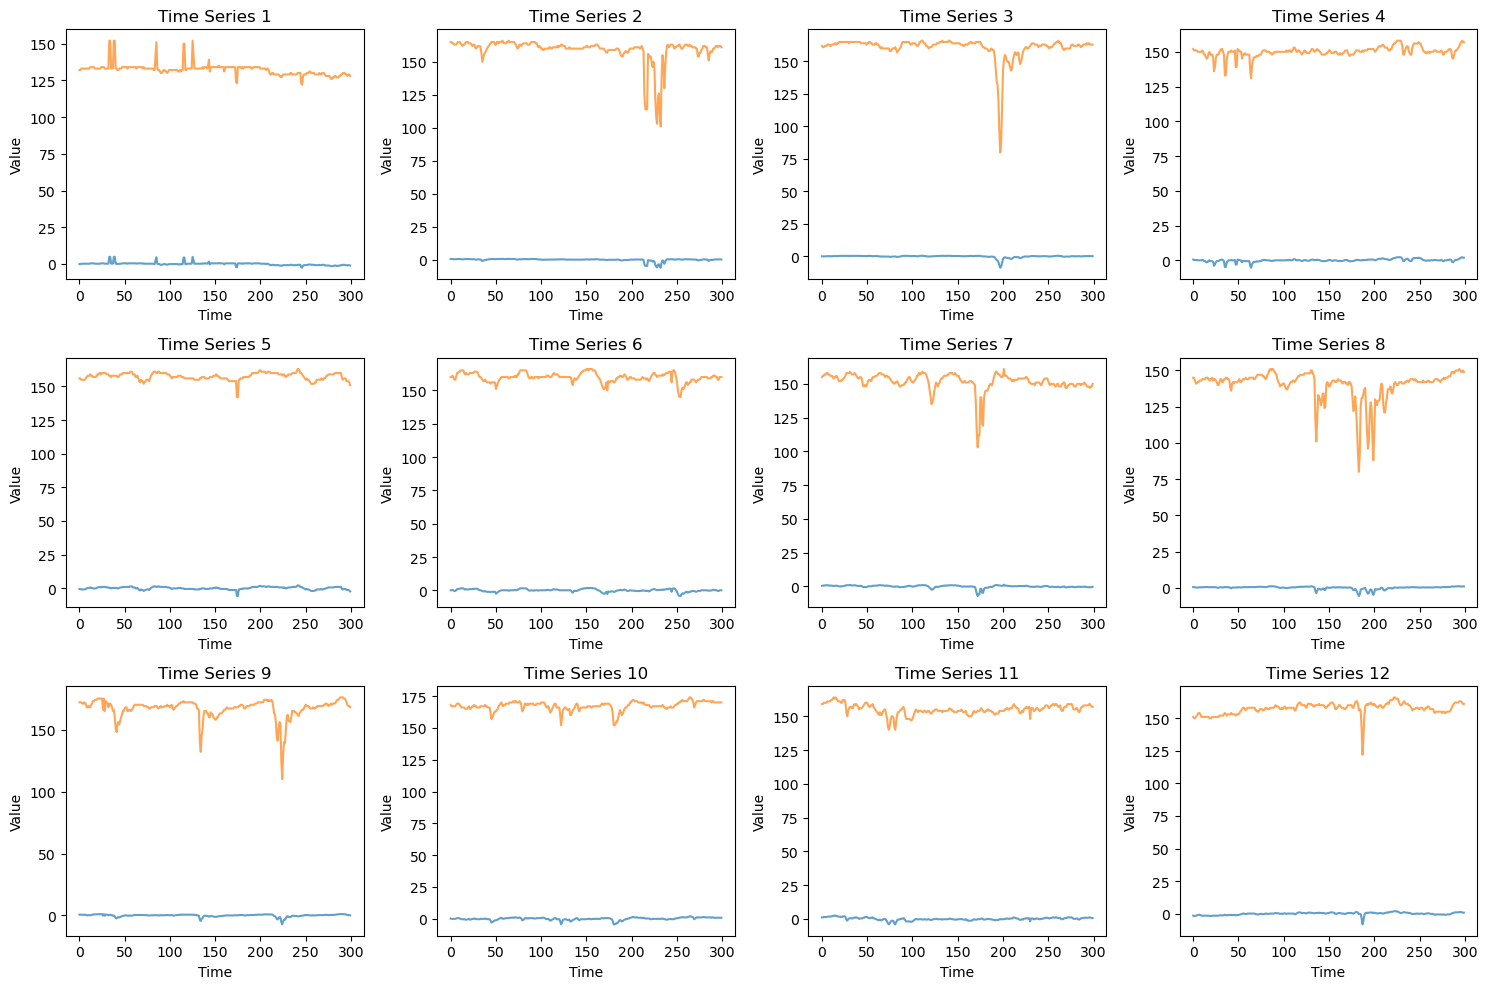

In [3]:
data_path = './data/PAS Challenge HR Data.xlsx'  
batch_size = 128
train_dataloader, test_dataloader, df_scaled, df = prepare_data(data_path, batch_size=batch_size)
dataset = VSTSDataset(df_scaled)

In [3]:
model_path = './script/VAE/results/hr_vae_linear_medium.pth' 
# Initialize model
model = VAE_Linear_Medium().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()


VAE_Linear_Medium(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=128, out_features=32, bias=True)
  (logvar_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(ne

In [4]:
K = 50 # number of augmentations for each sample
from tqdm import tqdm
df_aug = pd.DataFrame()
hr_mean_all = df.mean(axis=1)
hr_sd_all = df.std(axis=1)

for i in tqdm(range(len(dataset))):
    x = dataset[i]
    hr_mean = hr_mean_all[i]
    hr_sd = hr_sd_all[i]
    x_hat_ls = []
    euc_dist_ls = []
    for a in range(K): 
        # augment x k times
        distance = np.random.uniform(0, 5e-4)
        z_mean, z_log_var = model.encode(x)
        z = model.reparameterization(z_mean, z_log_var + distance)
        x_hat = model.decode(z) # length of 300
        z_mean_hat, z_log_var_hat = model.encode(x_hat)

        # Calculate Euclidean distance
        z_mean = z_mean.cpu().detach().numpy()
        z_mean_hat = z_mean_hat.cpu().detach().numpy()
        euc_dist = np.sqrt(np.sum((z_mean - z_mean_hat) ** 2))

        x_hat = x_hat.cpu().detach().numpy()
        hr_hat = x_hat * hr_sd + hr_mean
        x_hat_ls.append(hr_hat)
        euc_dist_ls.append(euc_dist)


    # Convert to numpy array with shape (K, 300)
    x_hat_ls = np.array(x_hat_ls)
    euc_dist_ls = np.array(euc_dist_ls)

    # Create the dataframe
    df_augmented = pd.DataFrame(x_hat_ls, columns=[str(i) for i in range(1, 301)])  # '1' to '300'
    # make all cells integer 
    df_augmented = df_augmented.round().astype(int)
    df_augmented.insert(0, 'rowid', [i] * K)  # Add rowid at the beginning
    df_augmented['euc_dist'] = euc_dist_ls     # Add euc_dist at the end

    df_aug = pd.concat([df_aug, df_augmented], ignore_index=True)

# save df_aug to csv
df_aug.to_csv('./data/hr_aug.csv', index=False)

  0%|          | 0/1849 [00:00<?, ?it/s]/var/folders/mx/85c6dr0j71n_d2rrwcc36l3m0000gn/T/ipykernel_49707/1738413687.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hr_mean = hr_mean_all[i]
/var/folders/mx/85c6dr0j71n_d2rrwcc36l3m0000gn/T/ipykernel_49707/1738413687.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hr_sd = hr_sd_all[i]
/var/folders/mx/85c6dr0j71n_d2rrwcc36l3m0000gn/T/ipykernel_49707/1738413687.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 